In [1]:
import numpy as np              # для матриц и математики
import pandas as pd             # для работы с табличками
from scipy import stats         # для работы со статистикой
import matplotlib.pyplot as plt # для визуализации
import statsmodels.api as api
import statsmodels.tsa.stattools as ts
from sklearn.metrics import r2_score

# для скачивания информации с html-страниц
import requests 
from bs4 import BeautifulSoup

plt.style.use('fivethirtyeight')

### 2. Скачаем датасет с ценой на нефть марки Brent с 1999 года по 2022 год:

In [384]:
URL = 'https://worldtable.info/yekonomika/cena-na-neft-marki-brent-tablica-s-1986-po-20.html?ysclid=l9e4pvjjpm293058322'
response = requests.get(URL)
soup = BeautifulSoup(response.text,'html.parser')

table = soup.find('table').tbody
rows = table.find_all('tr')
columns = [v.text.replace('\n','') for v in rows[0].find_all('th')]

df = pd.DataFrame(columns=columns)

for i in range(1,len(rows)):
    tds = rows[i].find_all('td')

    if len(tds)==4:
        values = [tds[0].text, tds[1].text, tds[2].text, tds[3].text.replace('\n',''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n',''.replace('\xa0','')) for td in tds]

    df = df.append(pd.Series(values, index=['Date', 'Mean price', 'Changing']), ignore_index=True)

    df.to_csv('oil_price.csv',index=False)

### 3.

In [2]:
ruble_rate_df = pd.read_excel('./reer_neer.xlsx')
ruble_rate_df.columns = ['month', 'reer', 'neer']
ruble_rate_df

,month,reer,neer
0,1999M01,43.385484,106.584831
1,1999M02,45.554806,108.700998
2,1999M03,47.214643,110.850913
3,1999M04,46.592002,107.367164
4,1999M05,48.068810,109.411444
...,...,...,...
280,2022M05,108.536678,70.362250
281,2022M06,124.941977,80.007951
282,2022M07,128.159071,80.841809
283,2022M08,126.120141,78.274269


Приведем столбец `Month` к типу `datetime64`:

In [3]:
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M01': '-01-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M02': '-02-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M03': '-03-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M04': '-04-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M05': '-05-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M06': '-06-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M07': '-07-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M08': '-08-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M09': '-09-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M10': '-10-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M11': '-11-01'}, regex=True)
ruble_rate_df['month'] = ruble_rate_df['month'].replace({'M12': '-12-01'}, regex=True)

In [4]:
ruble_rate_df['month'] = ruble_rate_df['month'].astype('datetime64')

Обрежем данные по дате (1999-2021):

In [5]:
ruble_rate_df = ruble_rate_df[(ruble_rate_df['month'] >= '01-01-1999') & (ruble_rate_df['month'] < '01-01-2022')]

### 4.

In [6]:
oil_price_df = pd.read_csv('./oil_price.csv')
oil_price_df = oil_price_df.drop(columns=['Changing'])
oil_price_df.columns = ['month', 'poil']
oil_price_df.head()

,month,poil
0,февраль 1986,17.32
1,март 1986,13.85
2,апрель 1986,12.48
3,май 1986,14.05
4,июнь 1986,11.90


Приведем столбец `Month` к типу `datetime64`:

In [7]:
oil_price_df['month'] = oil_price_df['month'].replace({'январь ': '01-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'февраль ': '02-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'март ': '03-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'апрель ': '04-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'май ': '05-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'июнь ': '06-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'июль ': '07-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'август ': '08-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'сентябрь ': '09-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'октябрь ': '10-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'ноябрь ': '11-'}, regex=True)
oil_price_df['month'] = oil_price_df['month'].replace({'декабрь ': '12-'}, regex=True)

In [8]:
oil_price_df = oil_price_df[oil_price_df['month'] != '03-2020 (16-31 марта)']
oil_price_df['month'] = oil_price_df['month'].replace({'03-2020 (1-15 марта)': '03-2020'}, regex=False)

In [9]:
oil_price_df['month'] = oil_price_df['month'].astype('datetime64')

Обрежем данные по дате (1999-2021):

In [10]:
oil_price_df = oil_price_df[(oil_price_df['month'] >= '01-01-1999') & (oil_price_df['month'] < '01-01-2022')]

### 4. Соединение таблиц

In [11]:
df = pd.merge(ruble_rate_df, oil_price_df, how = 'inner', on = 'month')
df = df.set_index('month')
df.head(3)

,reer,neer,poil
month,,,
1999-01-01,43.385484,106.584831,10.95
1999-02-01,45.554806,108.700998,10.20
1999-03-01,47.214643,110.850913,12.12


Создадим дополнительные нужные нам столбцы, а именно:
1. `log_reer` - отлогарифмированный реальный эффективный курс рубля.
3. `log_poil` - отлогарифмированная цена на нефть в рублях.

In [12]:
df['log_reer'] = df['reer'].apply(lambda x: np.log(x))
df['log_poil'] = df['poil'].apply(lambda x: np.log(x))

In [13]:
df.head(3)

,reer,neer,poil,log_reer,log_poil
month,,,,,
1999-01-01,43.385484,106.584831,10.95,3.770125,2.393339
1999-02-01,45.554806,108.700998,10.20,3.818916,2.322388
1999-03-01,47.214643,110.850913,12.12,3.854704,2.494857


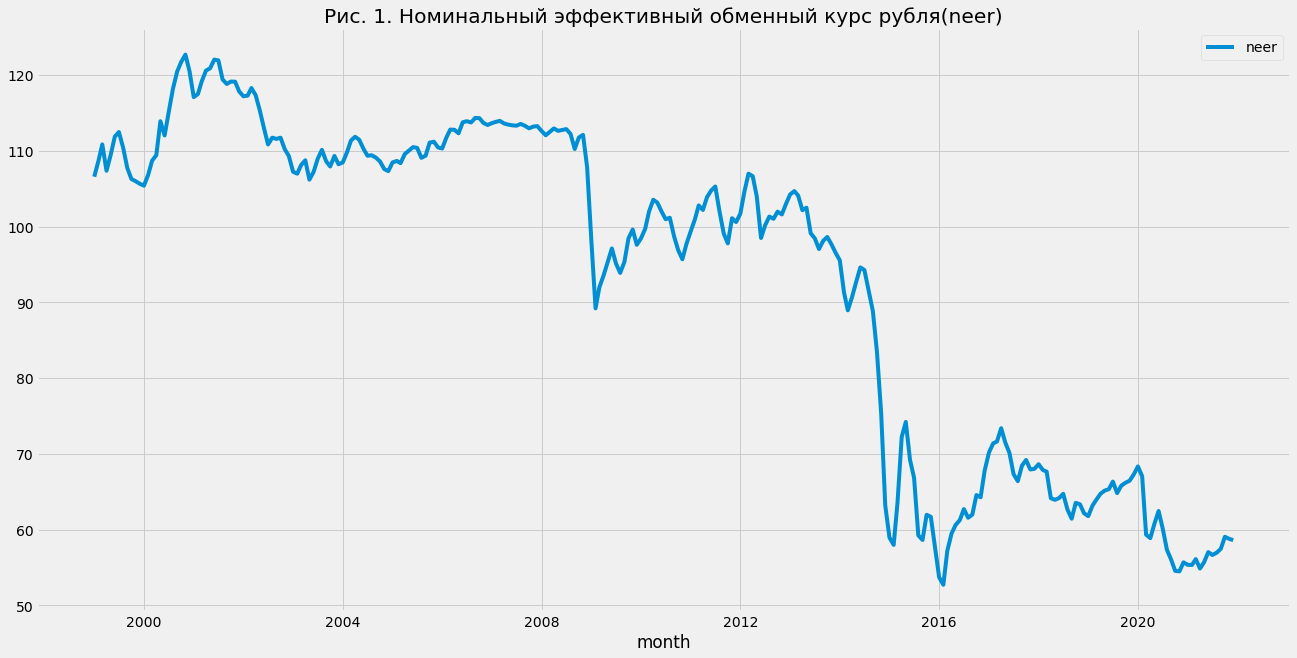

In [14]:
plt.figure(figsize=(20,10))
plt.plot(df['neer'], label='neer')
plt.legend()
plt.xlabel('month')
plt.title('Рис. 1. Номинальный эффективный обменный курс рубля(neer)')
None

Построим теперь графики:

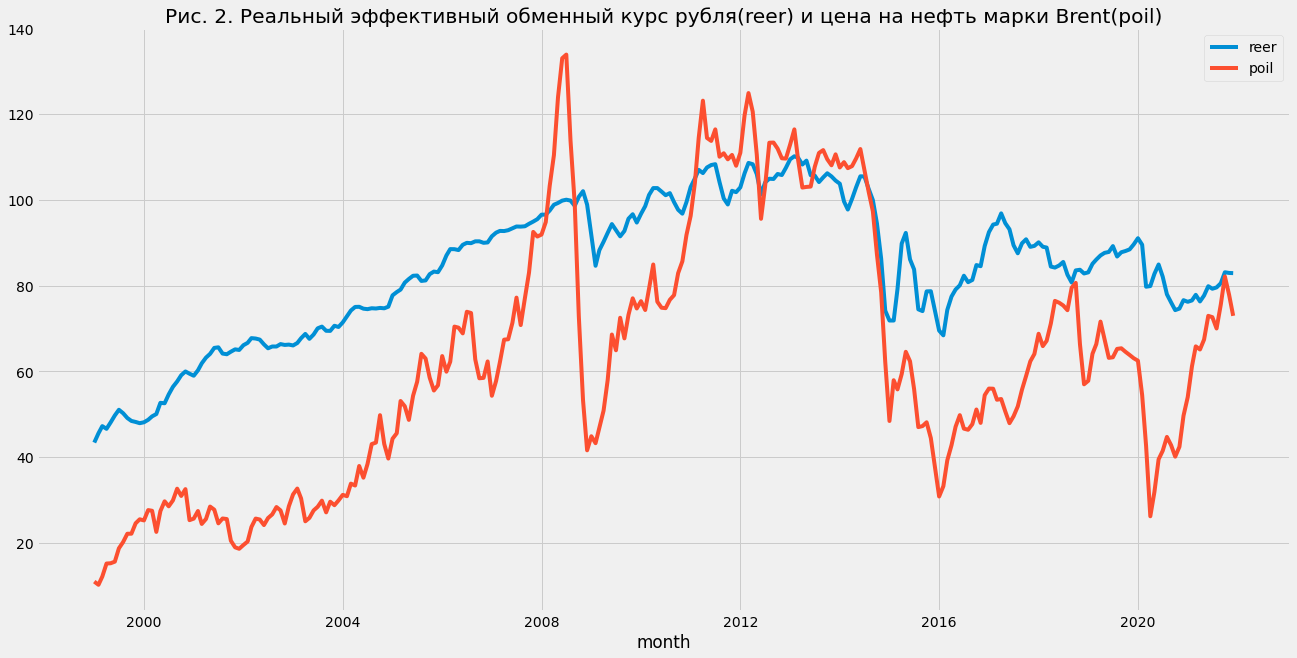

In [15]:
plt.figure(figsize=(20,10))
plt.plot(df['reer'], label='reer')
plt.plot(df['poil'], label='poil')
plt.legend()
plt.xlabel('month')
plt.title('Рис. 2. Реальный эффективный обменный курс рубля(reer) и цена на нефть марки Brent(poil)')
None

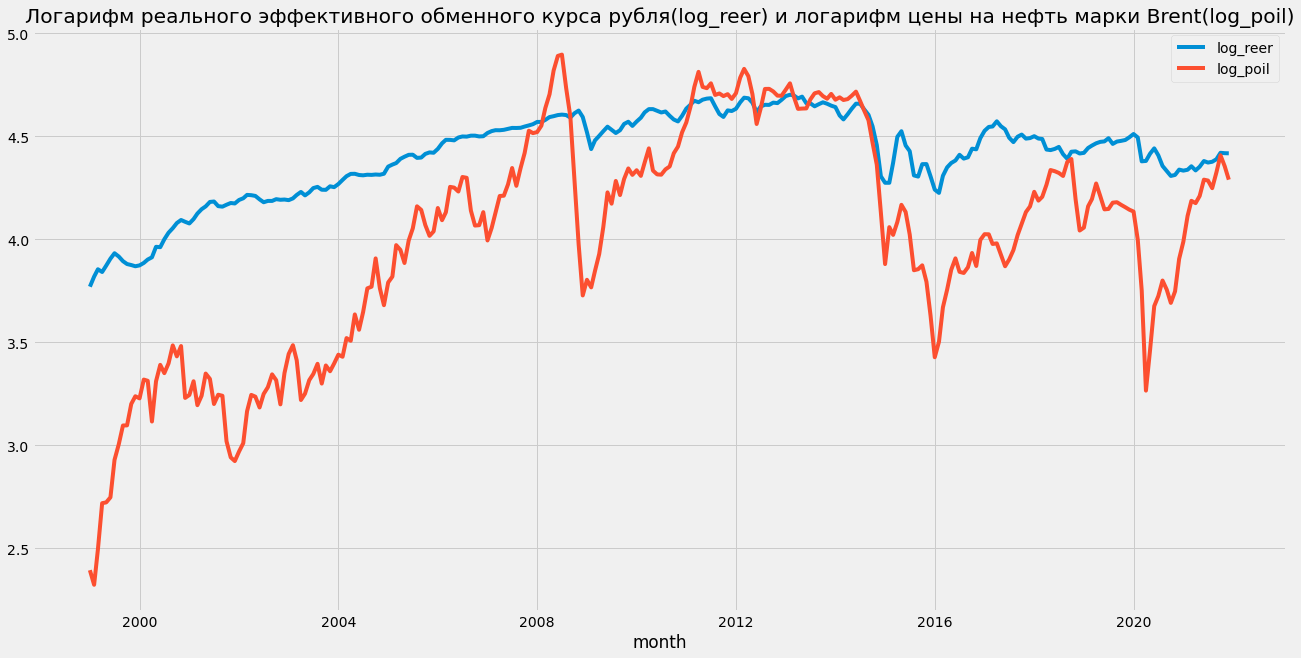

In [16]:
plt.figure(figsize=(20,10))
plt.plot(df['log_reer'], label='log_reer')
plt.plot(df['log_poil'], label='log_poil')
plt.legend()
plt.xlabel('month')
plt.title('Логарифм реального эффективного обменного курса рубля(log_reer) и логарифм цены на нефть марки Brent(log_poil)')
None

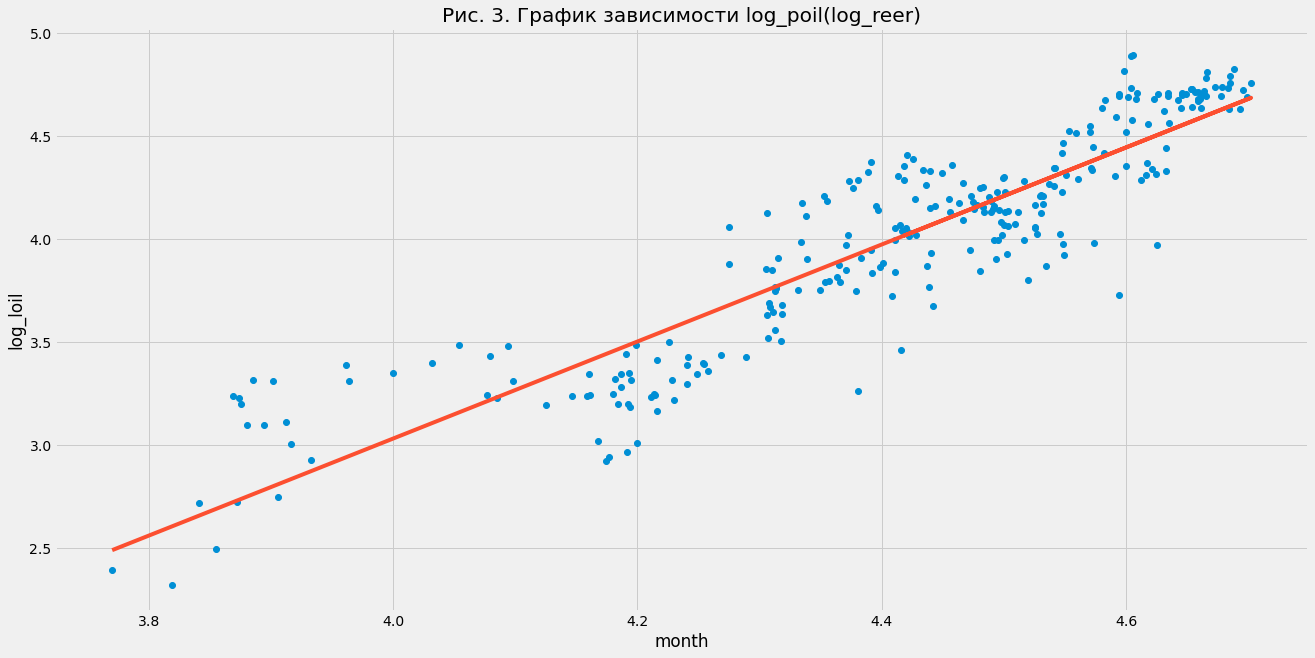

In [17]:
p = np.polyfit(df['log_reer'], df['log_poil'] ,1)


plt.figure(figsize=(20,10))
plt.plot(df['log_reer'], df['log_poil'], 'o')
plt.plot(df['log_reer'], np.polyval(p, df['log_reer']))
plt.ylabel('log_loil')
plt.xlabel('log_reer')
plt.xlabel('month')
plt.title('Рис. 3. График зависимости log_poil(log_reer)')
None

### 5. Проверка стационарности

1) Для `reer`. 

In [18]:
df.head(3)

,reer,neer,poil,log_reer,log_poil
month,,,,,
1999-01-01,43.385484,106.584831,10.95,3.770125,2.393339
1999-02-01,45.554806,108.700998,10.20,3.818916,2.322388
1999-03-01,47.214643,110.850913,12.12,3.854704,2.494857


In [19]:
test = ts.adfuller(df['reer'])
print('Таблица 1. Результаты ADF-теста на стационарность reer_t.')
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')

Таблица 1. Результаты ADF-теста на стационарность reer_t.
adf:  -2.485314380606089
p-value:  0.11908850504075452
Critical values:  {'1%': -3.4546223782586534, '5%': -2.8722253212300277, '10%': -2.5724638500216264}
Есть единичные корни, ряд не стационарен.


In [20]:
diff1 = df['reer'].diff(periods=1).dropna()

In [21]:
test = ts.adfuller(diff1)
print('Таблица 2. Результаты ADF-теста на стационарность d_reer_t.')
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')

Таблица 2. Результаты ADF-теста на стационарность d_reer_t.
adf:  -10.762101429782925
p-value:  2.505626792012591e-19
Critical values:  {'1%': -3.4546223782586534, '5%': -2.8722253212300277, '10%': -2.5724638500216264}
Единичных корней нет, ряд стационарен.


!! Написать вывод !!

2) Для `poil`:

!! Написать, что мы тут проверяем, как тут https://habr.com/ru/post/207160/

In [22]:
test = ts.adfuller(df['poil'])
print('Таблица 3. Результаты ADF-теста на стационарность poil_t.')
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')

Таблица 3. Результаты ADF-теста на стационарность poil_t.
adf:  -2.6553424925967124
p-value:  0.08208984229562821
Critical values:  {'1%': -3.4544435065994437, '5%': -2.8721468827772774, '10%': -2.572422013959188}
Есть единичные корни, ряд не стационарен.


In [23]:
diff1 = df['poil'].diff(periods=1).dropna()

In [24]:
test = ts.adfuller(diff1)
print('Таблица 4. Результаты ADF-теста на стационарность d_poil_t.')
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')

Таблица 4. Результаты ADF-теста на стационарность d_poil_t.
adf:  -10.798067794388375
p-value:  2.0511160875109686e-19
Critical values:  {'1%': -3.4544435065994437, '5%': -2.8721468827772774, '10%': -2.572422013959188}
Единичных корней нет, ряд стационарен.


3) Регрессия на отлогарифмированных величинах:

Нам надо понять, имеет ли место для некоторого $b$:
$$log\_reer_t - b\cdot log\_poil_t\sim I(0)$$
Или же:
$$\forall b:~log\_reer_t - b\cdot log\_poil_t\sim I(1)$$
Для этого оценим параметр $b$ методом наименьших квадратов: 
$$b=\frac{cov(log\_reer_t,log\_poil_t)}{var(log\_poil_t)}$$

In [25]:
df.cov()

,reer,neer,poil,log_reer,log_poil
reer,259.242147,-37.777093,427.223124,3.360637,8.055245
neer,-37.777093,472.725586,-34.291027,-0.716410,-2.150924
poil,427.223124,-34.291027,899.062297,5.366354,15.682673
log_reer,3.360637,-0.716410,5.366354,0.044261,0.104321
log_poil,8.055245,-2.150924,15.682673,0.104321,0.296854


In [26]:
b = 0.104321 / 0.296854

In [28]:
reg = df['log_reer'] - b * df['log_poil']
test = ts.adfuller(reg)
print('Таблица 5. Результаты ADF-теста на стационарность log(reer_t)-b log(poil_t).')
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')

Таблица 5. Результаты ADF-теста на стационарность log(reer_t)-b log(poil_t).
adf:  -3.965611495212391
p-value:  0.0016016797829541064
Critical values:  {'1%': -3.4544435065994437, '5%': -2.8721468827772774, '10%': -2.572422013959188}
Единичных корней нет, ряд стационарен.


Значит, ряды `log_reer` и `log_poil` коинтегрированы.

### 6. Построение моделей

Обозначим:  `df['log_reer']`=$y_t$, `df['log_poil']`=$x_t$. Тогда по результатам тестов из предыдущего пункта мы получили: $y_t\sim I(1)$ (т.е. это интегрированная переменная порядка 1), $x_t\sim I(1)$ (т.е. это интегрированная переменная порядка 1), связь этих временных рядов **паразитная** 
(т.е. $\forall b: y_t-bx_t\sim I(1)$).

1) Модель для данных t < ноябрь 2014 года:

In [60]:
df1 = df[:'2014-10-01']
df1.head(10)

,reer,neer,poil,log_reer,log_poil
month,,,,,
1999-01-01,43.385484,106.584831,10.95,3.770125,2.393339
1999-02-01,45.554806,108.700998,10.20,3.818916,2.322388
1999-03-01,47.214643,110.850913,12.12,3.854704,2.494857
1999-04-01,46.592002,107.367164,15.16,3.841429,2.718660
1999-05-01,48.068810,109.411444,15.22,3.872634,2.722610
1999-06-01,49.708848,111.877942,15.60,3.906183,2.747271
1999-07-01,51.032449,112.482726,18.71,3.932462,2.929058
1999-08-01,50.229686,110.426724,20.17,3.916606,3.004196
1999-09-01,49.110186,107.717879,22.11,3.894066,3.096030


In [61]:
z = df1['log_reer'] - b * df1['log_poil']
z = z - z.mean()

y = df1['log_reer'].to_numpy()
x = df1['log_poil'].to_numpy()
dy = df1['log_reer'].diff(periods=1).to_numpy()
dx = df1['log_poil'].diff(periods=1).to_numpy()

In [62]:
X = [np.ones(df1.shape[0]-6),z[6:],dx[6:],dx[5:-1],dx[4:-2],dx[3:-3],dx[2:-4],dx[1:-5],
     dy[5:-1],dy[4:-2],dy[3:-3],dy[2:-4],dy[1:-5]]
Y = dy[6:]

X = np.array(X).T
X = pd.DataFrame(X)
X.columns = ['const', 'z_t', 'dx_t', 'dx_{t-1}', 'dx_{t-2}', 'dx_{t-3}', 'dx_{t-4}', 'dx_{t-5}',
             'dy_{t-1}', 'dy_{t-2}', 'dy_{t-3}', 'dy_{t-4}', 'dy_{t-5}']

In [63]:
model_11 = api.OLS(Y, X[['const', 'z_t', 'dx_t', 'dx_{t-1}', 'dx_{t-2}', 'dx_{t-3}', 'dx_{t-4}', 'dx_{t-5}',
             'dy_{t-1}', 'dy_{t-2}', 'dy_{t-3}', 'dy_{t-4}', 'dy_{t-5}']])
results_11 = model_11.fit()
print('Таблица 6. Результаты оценивания на 1-ом интервале(1999M1<=t<2014M11).\n')
print(results_11.summary())

Таблица 6. Результаты оценивания на 1-ом интервале(1999M1<=t<2014M11).

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     4.850
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           7.58e-07
Time:                        13:21:35   Log-Likelihood:                 497.97
No. Observations:                 184   AIC:                            -969.9
Df Residuals:                     171   BIC:                            -928.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

Из таблицы видно, что на уровне значимости 5% следующие коэффициенты можно считать стат. незначимыми:
`const`, `z_t`, `dx_{t-1}`, `dx_{t-3}`, `dx_{t-4}`, `dx_{t-5}`, `dy_{t-3}`, `dy_{t-4}`, `dy_{t-5}`. В связи с этим построим новую модель со следующими временными рядами: `dx_t`, `dx_{t-2}`, `dy_{t-1}`, `dy_{t-2}`:

In [64]:
model_12 = api.OLS(Y, X[['dx_t', 'dx_{t-2}', 'dy_{t-1}', 'dy_{t-2}']])
results_12 = model_12.fit()
print('Таблица 8. Результаты оценивания на 1-ом интервале(1999M1<=t<2014M11).\n')
print(results_12.summary())

Таблица 8. Результаты оценивания на 1-ом интервале(1999M1<=t<2014M11).

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.253
Model:                            OLS   Adj. R-squared (uncentered):              0.237
Method:                 Least Squares   F-statistic:                              15.28
Date:                Tue, 06 Dec 2022   Prob (F-statistic):                    8.91e-11
Time:                        13:21:37   Log-Likelihood:                          494.77
No. Observations:                 184   AIC:                                     -981.5
Df Residuals:                     180   BIC:                                     -968.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t     

Видно, что уже для данной модели все коэффициенты стат. значимы на уровне значимости 5%.

Создадим временной ряд, который будет содержать предсказания нашей модели(величины `log_reer`) на 1-ом промежутке:

In [65]:
dy_pred = results_12.predict()

y_pred = np.zeros(185)
y_pred[0] = y[5]
for i in range(184):
    y_pred[i+1] = y_pred[i] + dy_pred[i]
    
df1_ = df1['1999-06-01':]
df1_['pred'] = y_pred

/var/folders/tx/jc8_0sl92klfzzmp_l613pxc0000gn/T/ipykernel_89058/2413620287.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_['pred'] = y_pred


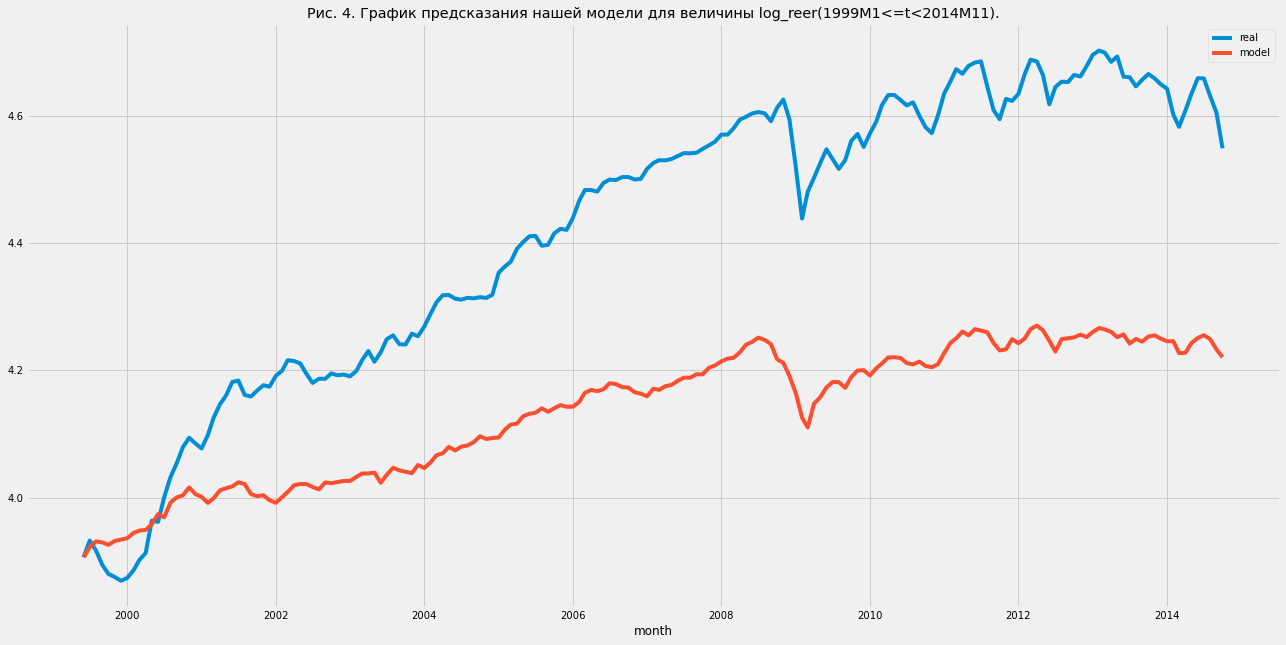

In [66]:
plt.figure(figsize=(20,10))
plt.plot(df1_['log_reer'], label='real')
plt.plot(df1_['pred'], label='model')
plt.legend()
plt.xlabel('month')
plt.title('Рис. 4. График предсказания нашей модели для величины log_reer(1999M1<=t<2014M11).')

None

2) Модель для данных ноябрь 2014 года <= t < январь 2021 года:

In [55]:
df2 = df['2014-05-01':]
df2

,reer,neer,poil,log_reer,log_poil
month,,,,,
2014-05-01,102.953373,92.675506,109.68,4.634276,4.697567
2014-06-01,105.505757,94.613273,111.87,4.658766,4.717337
2014-07-01,105.476199,94.257899,106.98,4.658485,4.672642
2014-08-01,102.596159,91.582467,101.92,4.630800,4.624188
2014-09-01,99.952462,88.840317,97.34,4.604695,4.578210
...,...,...,...,...,...
2021-08-01,79.580192,56.940574,70.00,4.376765,4.248495
2021-09-01,80.556561,57.457116,75.59,4.388960,4.325324
2021-10-01,83.118523,59.047686,82.13,4.420268,4.408303


In [56]:
z = df2['log_reer'] - b * df2['log_poil']
z = z - z.mean()

y = df2['log_reer'].to_numpy()
x = df2['log_poil'].to_numpy()
dy = df2['log_reer'].diff(periods=1).to_numpy()
dx = df2['log_poil'].diff(periods=1).to_numpy()

In [57]:
X = [np.ones(df2.shape[0]-6),z[6:],dx[6:],dx[5:-1],dx[4:-2],dx[3:-3],dx[2:-4],dx[1:-5],
     dy[5:-1],dy[4:-2],dy[3:-3],dy[2:-4],dy[1:-5]]
Y = dy[6:]

X = np.array(X).T
X = pd.DataFrame(X)
X.columns = ['const', 'z_t', 'dx_t', 'dx_{t-1}', 'dx_{t-2}', 'dx_{t-3}', 'dx_{t-4}', 'dx_{t-5}',
             'dy_{t-1}', 'dy_{t-2}', 'dy_{t-3}', 'dy_{t-4}', 'dy_{t-5}']

In [58]:
model_21 = api.OLS(Y, X[['const', 'z_t', 'dx_t', 'dx_{t-1}', 'dx_{t-2}', 'dx_{t-3}', 'dx_{t-4}', 'dx_{t-5}',
             'dy_{t-1}', 'dy_{t-2}', 'dy_{t-3}', 'dy_{t-4}', 'dy_{t-5}']])
results_21 = model_21.fit()
print('Таблица 7. Результаты оценивания на 2-ом интервале(2014M11<=t<2022M1).\n')
print(results_21.summary())

Таблица 7. Результаты оценивания на 2-ом интервале(2014M11<=t<2022M1).

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     4.546
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           1.96e-05
Time:                        13:19:50   Log-Likelihood:                 177.05
No. Observations:                  86   AIC:                            -328.1
Df Residuals:                      73   BIC:                            -296.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

Из таблицы видно, что на уровне значимости 5% следующие коэффициенты можно считать стат. незначимыми:
`const`, `dx_{t-1}`, `dx_{t-2}`, `dx_{t-3}`, `dx_{t-4}`, `dx_{t-5}`, `dy_{t-1}`, `dy_{t-2}`, `dy_{t-3}`, `dy_{t-4}`, `dy_{t-5}`. В связи с этим построим новую модель со следующими временными рядами: `z_t`, `dx_t`(решено было оставить 1 элемент авторегрессии(был выбран как $argmax$ качества), так как без него качество сильно хуже):

In [59]:
model_22 = api.OLS(Y, X[['z_t', 'dx_t', 'dy_{t-3}']])
results_22 = model_22.fit()
print('Таблица 9. Результаты оценивания на 2-ом интервале(2014M11<=t<2022M1).\n')
print(results_22.summary())

Таблица 9. Результаты оценивания на 2-ом интервале(2014M11<=t<2022M1).

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.330
Model:                            OLS   Adj. R-squared (uncentered):              0.306
Method:                 Least Squares   F-statistic:                              13.64
Date:                Tue, 06 Dec 2022   Prob (F-statistic):                    2.58e-07
Time:                        13:19:51   Log-Likelihood:                          170.23
No. Observations:                  86   AIC:                                     -334.5
Df Residuals:                      83   BIC:                                     -327.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t     

Видно, что уже для данной модели все коэффициенты стат. значимы на уровне значимости 5%.

Создадим временной ряд, который будет содержать предсказания нашей модели(величины `log_reer`) на 2-ом промежутке:

In [42]:
dy_pred = results_22.predict()

y_pred = np.zeros(87)
y_pred[0] = y[5]
for i in range(86):
    y_pred[i+1] = y_pred[i] + dy_pred[i]
    
df2_ = df2['2014-10-01':]
df2_['pred'] = y_pred

/var/folders/tx/jc8_0sl92klfzzmp_l613pxc0000gn/T/ipykernel_89058/824284995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_['pred'] = y_pred


3) Построим итоговый график предсказания нашей модели(для сравнения приведена реальный временной ряд `log_reer`):

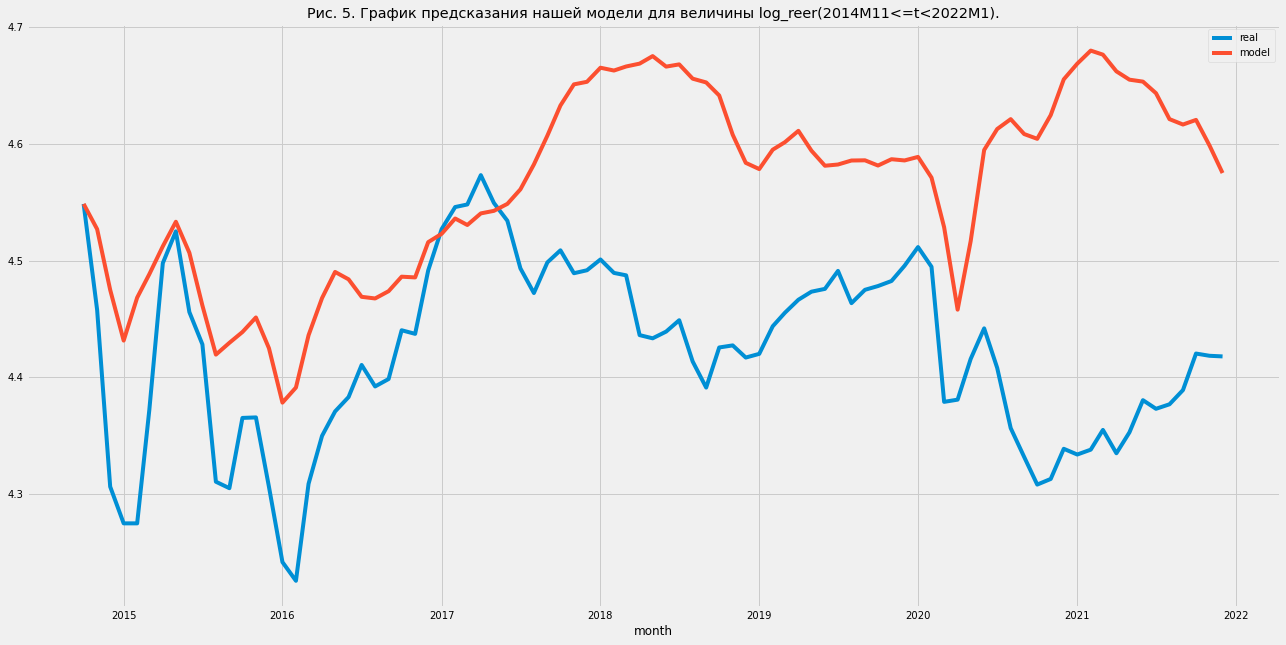

In [67]:
plt.figure(figsize=(20,10))

plt.plot(df2_['log_reer'], label='real')
plt.plot(df2_['pred'], label='model')
plt.legend()
plt.xlabel('month')
plt.title('Рис. 5. График предсказания нашей модели для величины log_reer(2014M11<=t<2022M1).')

None

### 7. Применимы ли построенные модели для данных за 2022 год?

1) Сделаем таблицу с данными для 2022 года:

In [68]:

date = ['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01']
poil = [75.41, 72.99, 78.52, 83.49, 70.57, 77.78, 91.21, 100.99, 107.90, 107.10, 122.80, 114.80, 103.30, 96.49, 87.96]
reer = [79.27, 79.58, 80.56, 83.12, 82.96, 82.91, 80.50, 79.49, 64.85, 87.38, 108.54, 124.94, 128.16, 126.12, 130.40]
    
    
df_2022 = pd.DataFrame()
df_2022['month'] = date
df_2022['reer'] = reer
df_2022['poil'] = poil
df_2022 = df_2022.set_index('month')
df_2022['log_reer'] = df_2022['reer'].apply(lambda x: np.log(x))
df_2022['log_poil'] = df_2022['poil'].apply(lambda x: np.log(x))

df_2022.head(5)

,reer,poil,log_reer,log_poil
month,,,,
2021-07-01,79.27,75.41,4.372860,4.322940
2021-08-01,79.58,72.99,4.376763,4.290322
2021-09-01,80.56,78.52,4.389002,4.363353
2021-10-01,83.12,83.49,4.420285,4.424727
2021-11-01,82.96,70.57,4.418359,4.256605


2) График:

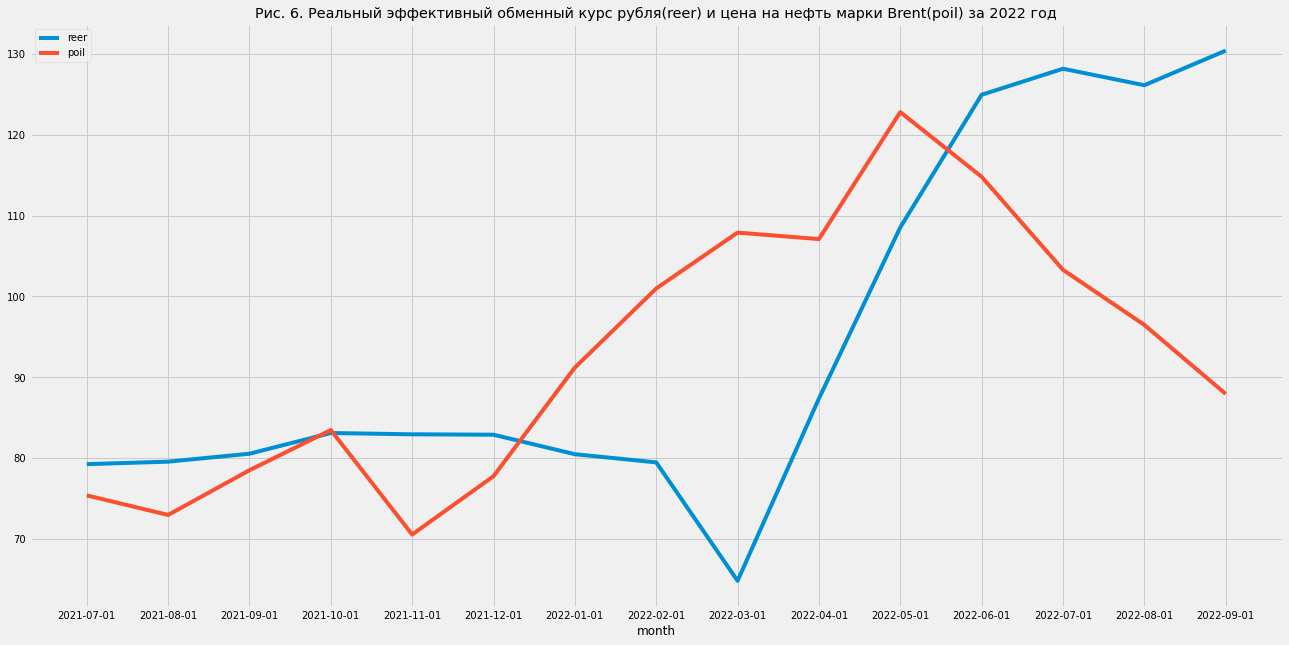

In [70]:
plt.figure(figsize=(20,10))
plt.plot(df_2022['reer'], label='reer')
plt.plot(df_2022['poil'], label='poil')
plt.legend()
plt.rc('font', size=10)   
plt.xlabel('month')
plt.title('Рис. 6. Реальный эффективный обменный курс рубля(reer) и цена на нефть марки Brent(poil) за 2022 год')
None

3) Что на этом интервале предсказывают модели:

In [46]:
z = df_2022['log_reer'] - b * df_2022['log_poil']
z = z - z.mean()

y = df_2022['log_reer'].to_numpy()
x = df_2022['log_poil'].to_numpy()
dy = df_2022['log_reer'].diff(periods=1).to_numpy()
dx = df_2022['log_poil'].diff(periods=1).to_numpy()

In [47]:
X = [np.ones(df_2022.shape[0]-6),z[6:],dx[6:],dx[5:-1],dx[4:-2],dx[3:-3],dx[2:-4],dx[1:-5],
     dy[5:-1],dy[4:-2],dy[3:-3],dy[2:-4],dy[1:-5]]
Y = dy[6:]

X = np.array(X).T
X = pd.DataFrame(X)
X.columns = ['const', 'z_t', 'dx_t', 'dx_{t-1}', 'dx_{t-2}', 'dx_{t-3}', 'dx_{t-4}', 'dx_{t-5}',
             'dy_{t-1}', 'dy_{t-2}', 'dy_{t-3}', 'dy_{t-4}', 'dy_{t-5}']

In [51]:
print('R2-score для 1-ой модели на промежутке t>2021M12:', 
      r2_score(Y, results_12.predict(X[['dx_t', 'dx_{t-2}', 'dy_{t-1}', 'dy_{t-2}']])))

R2-score для 1-ой модели на промежутке t>2021M12: -0.17777235176161477


In [52]:
print('R2-score для 2-ой модели на промежутке t>2021M12:', r2_score(Y , results_22.predict(X[['z_t', 'dx_t', 'dy_{t-3}']])))

R2-score для 2-ой модели на промежутке t>2021M12: 0.01328191124077216


Видно, что качество на несколько порядков хуже, чем на интервалах, на которых были обучены эти модели. Поэтому можно выдвинуть предположение, что модели совершенно не подходят для предсказания реального эффективного обменного курса рубля на период после 2021 года. 